# Clustering and Similarity

* **Name:** Aldo Barriente
* **Email:** aib9jp@virginia.edu
* **Course:** DS 5001
* **Date:** 20 April 2021

## Set up

In [1]:
n_terms = 4000

In [2]:
data_in = './data_in/'
data_out = './data_out/'
data_prefix = 'zapatistas'

In [3]:
OHCO = ['text_id', 'section_num', 'para_num', 'sent_num', 'token_num']
PARA = OHCO[:3]
SECTION = OHCO[:2]
TEXT = OHCO[:1]

In [4]:
import pandas as pd
import numpy as np
import re 
from numpy.linalg import norm
from scipy.spatial.distance import pdist, squareform

## Importing tables

In [5]:
LIB = pd.read_csv(f'{data_in}/{data_prefix}-LIB.csv')
TOKEN = pd.read_csv(f'{data_in}/{data_prefix}-TOKEN.csv').set_index(OHCO)
VOCAB = pd.read_csv(f'{data_in}/{data_prefix}-VOCAB.csv').dropna().set_index('term_str')

In [6]:
LIB = LIB.drop(columns=['Unnamed: 0']).set_index('text_id')

In [7]:
LIB = LIB.sort_index()

In [8]:
LIB

,text_title,text_file
text_id,,
1,The Revolt,./data_in\zapatistas-ch1.txt
2,The First Days,./data_in\zapatistas-ch2.txt
3,The Cease - Fire,./data_in\zapatistas-ch3.txt
4,Solidarity,./data_in\zapatistas-ch4.txt
5,Broadening the Struggle,./data_in\zapatistas-ch5.txt
6,Building Ties,./data_in\zapatistas-ch6.txt
7,Before the Dialogue,./data_in\zapatistas-ch7.txt
8,The Dialogue,./data_in\zapatistas-ch8.txt
9,Concluding the Dialogue,./data_in\zapatistas-ch9.txt


## `TFIDF` Matrix

### Function

In [9]:
def get_tfidf(bag, tf_method='sum', item_type='term_str'):
    
    global TOKEN, VOCAB
    
    # Create bag of items (terms or stems)
    BOW = TOKEN.groupby(bag+[item_type])[item_type].count()\
        .to_frame().rename(columns={item_type:'n'})

    # Add binary count column
    BOW['c'] = BOW.n.astype('bool').astype('int')

    # Compute TF
    D = BOW.groupby(bag).n
    if tf_method == 'sum':
        BOW['tf'] = D.apply(lambda x: x / x.sum())
    elif tf_method == 'max':
        BOW['tf'] = D.apply(lambda x: .4 + .6 * (x / x.max())) # See Manning, et al. for choice of α
    elif tf_method == 'bool':
        BOW['tf'] = D.apply(lambda x: x.astype('bool') / x.astype('bool').sum())
    elif tf_method == 'raw':
        BOW['tf'] = BOW['n']
    elif tf_method == 'bool_raw':
        BOW['tf'] = BOW['c']
        
    # Compute DF
    VOCAB['df'] = BOW.groupby('term_str').n.count()
    N_docs = len(D.groups)
    VOCAB['idf'] = np.log2(N_docs/VOCAB.df)
    VOCAB['dfidf'] = VOCAB.df * VOCAB.idf
    
    # Compute TFIDF (local term significance)
    BOW['tfidf'] = BOW.apply(lambda x: x.tf * VOCAB.loc[x.name[2]].idf, 1) #BOW.tf * VOCAB.idf
    
    # Compute aggregate TFIDF (global term significance)
    VOCAB['tfidf_sum'] = BOW.groupby('term_str').tfidf.sum()
        
    return BOW

In [10]:
BOW = get_tfidf(SECTION, tf_method='max')

### Collapse by text

In [11]:
TFIDF = BOW.tfidf.unstack(fill_value=0)

In [12]:
TFIDF_text = TFIDF.groupby(TEXT).sum()

In [13]:
TFIDF_text

term_str,000001,001,002,029,036,038,044,055,062,1,...,zedillo,zero,zipper,zone,zones,zonethis,zoque,zócalo,zócalos,álvaro
text_id,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.548415,...,0.000000,0.000000,0.000000,2.056213,7.565802,0.000000,0.00000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.576708,...,0.000000,0.000000,0.000000,3.764415,1.219363,0.000000,0.00000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.348282,...,0.000000,0.000000,0.000000,2.818459,1.233375,0.000000,4.71353,0.000000,0.000000,2.763348
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.596487,...,0.000000,0.000000,0.000000,2.836475,1.226650,0.000000,0.00000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.112853,...,0.000000,2.370145,0.000000,1.869206,1.212191,0.000000,0.00000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.563312,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,2.035187,2.803851,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.774922,...,0.000000,2.335377,0.000000,1.931619,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.942031,...,0.000000,0.000000,0.000000,2.816868,1.214644,0.000000,0.00000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.361958,...,0.000000,0.000000,0.000000,0.928596,1.211656,0.000000,0.00000,0.000000,0.000000,0.000000


### Reducing features

In [14]:
VOCAB_SHORT = VOCAB.sort_values('tfidf_sum', ascending=False).head(n_terms).index.tolist()

In [15]:
TFIDF_text_short = TFIDF_text[VOCAB_SHORT]

In [16]:
LIB['tfidf_sum'] = TFIDF_text_short.sum(1).sort_index()
LIB['tfidf_mean'] = TFIDF_text_short.mean(1).sort_index()

<AxesSubplot:ylabel='text_title'>

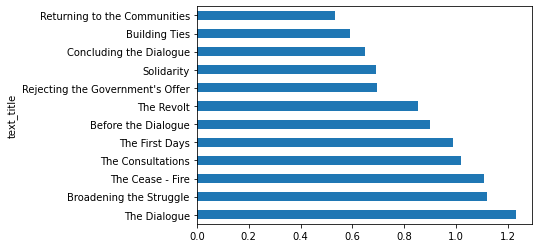

In [17]:
LIB.sort_values('tfidf_sum', ascending=False).reset_index().set_index('text_title').tfidf_mean.plot.barh()

### DOC Pair Table

In [18]:
PAIRS = pd.DataFrame(index=pd.MultiIndex.from_product([LIB.index.tolist(), LIB.index.tolist()])).reset_index()
PAIRS = PAIRS[PAIRS.level_0 < PAIRS.level_1].set_index(['level_0','level_1'])
PAIRS.index.names = ['doc_a', 'doc_b']

### Normalized Tables

In [19]:
df = TFIDF_text_short

In [20]:
L0 = df.astype('bool').astype('int') # Boolean
L1 = df.apply(lambda x: x / x.sum(), 1)
L2 = df.apply(lambda x: x / norm(x), 1)

## Computing Distances

In [21]:
PAIRS['cityblock'] = pdist(df, 'cityblock')
PAIRS['euclidean'] = pdist(df, 'euclidean')
PAIRS['cosine'] = pdist(df, 'cosine')
PAIRS['jaccard'] = pdist(L0, 'jaccard')
PAIRS['dice'] = pdist(L0, 'dice')
PAIRS['js'] = pdist(L1, 'jensenshannon')                               
PAIRS['euclidean2'] = pdist(L2, 'euclidean') # Should be the same as cosine (colinear)

## Dendrograms

In [22]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

In [23]:
LIB

,text_title,text_file,tfidf_sum,tfidf_mean
text_id,,,,
1,The Revolt,./data_in\zapatistas-ch1.txt,3404.833849,0.851208
2,The First Days,./data_in\zapatistas-ch2.txt,3946.819307,0.986705
3,The Cease - Fire,./data_in\zapatistas-ch3.txt,4422.099618,1.105525
4,Solidarity,./data_in\zapatistas-ch4.txt,2767.551815,0.691888
5,Broadening the Struggle,./data_in\zapatistas-ch5.txt,4475.751055,1.118938
6,Building Ties,./data_in\zapatistas-ch6.txt,2366.241261,0.591560
7,Before the Dialogue,./data_in\zapatistas-ch7.txt,3600.266918,0.900067
8,The Dialogue,./data_in\zapatistas-ch8.txt,4918.226172,1.229557
9,Concluding the Dialogue,./data_in\zapatistas-ch9.txt,2593.543853,0.648386


In [24]:
LABELS = LIB.apply(lambda x: "{}, {}".format(x.text_title, x.name), axis=1).values

In [25]:
def hca(sims, linkage_method='ward', color_thresh=.3, figsize=(5, 5)):
    tree = sch.linkage(sims, method=linkage_method)
    labels = LABELS
    plt.figure()
    fig, axes = plt.subplots(figsize=figsize)
    dendrogram = sch.dendrogram(tree, 
                                labels=labels, 
                                orientation="left", 
                                count_sort=True,
                                distance_sort=True,
                                above_threshold_color='.75',
                                color_threshold=color_thresh
                               )
    plt.tick_params(axis='both', which='major', labelsize=14)

### Cosine

<Figure size 432x288 with 0 Axes>

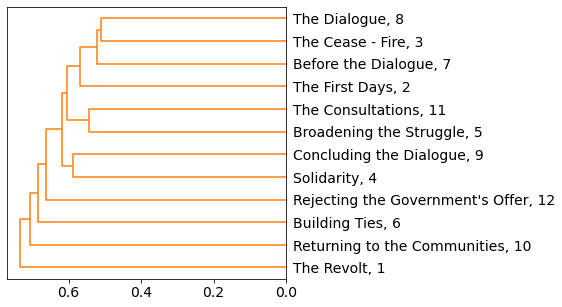

In [26]:
hca(PAIRS.cosine, color_thresh=1)

### JS

<Figure size 432x288 with 0 Axes>

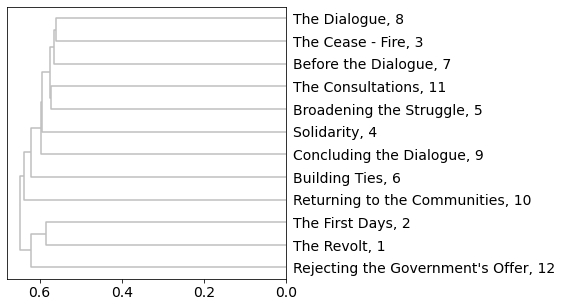

In [27]:
hca(PAIRS.js, linkage_method='weighted', color_thresh=.5)

### Jaccard

<Figure size 432x288 with 0 Axes>

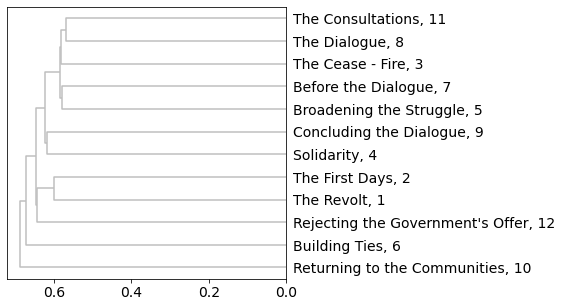

In [28]:
hca(PAIRS.jaccard, linkage_method='weighted', color_thresh=.3)

### Dice 

<Figure size 432x288 with 0 Axes>

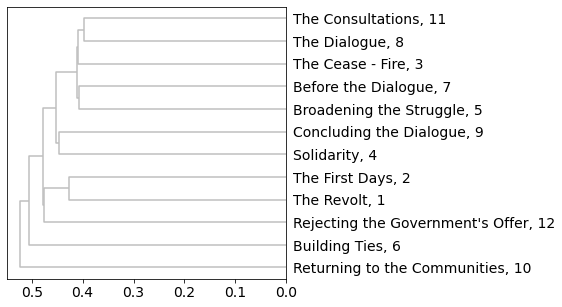

In [29]:
hca(PAIRS.dice, linkage_method='weighted', color_thresh=.3)

### Euclidean 

<Figure size 432x288 with 0 Axes>

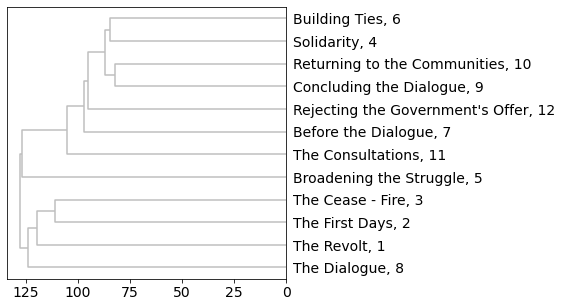

In [30]:
hca(PAIRS.euclidean, color_thresh=.3)

### Cityblock

<Figure size 432x288 with 0 Axes>

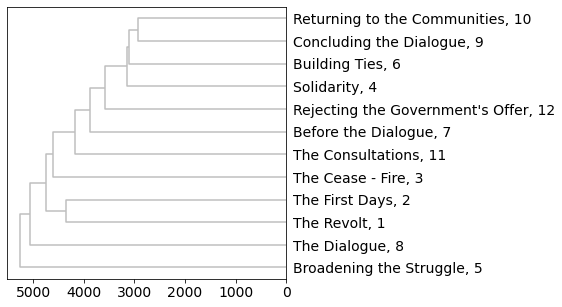

In [31]:
hca(PAIRS.cityblock, linkage_method='weighted', color_thresh=8)

## Saving 

In [32]:
TOKEN.to_csv(f'{data_out}/{data_prefix}-TOKEN.csv')
LIB.to_csv(f'{data_out}/{data_prefix}-LIB.csv')
VOCAB.to_csv(f'{data_out}/{data_prefix}-VOCAB.csv')